<a href="https://colab.research.google.com/github/matteolimoncini/glasses_or_no_glasses/blob/main/Glasses_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing useful libraries

In [1]:
%%capture
!pip install dask
!python -m pip install 'fsspec>=0.3.3'
!pip install kaggle
!pip install -q -U keras-tuner
!pip install split-folders

Import modules

In [2]:
import os
import shutil
from dask import dataframe as dd 
import tensorflow as tf
from random import randrange
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import math
import splitfolders
import pickle
import pandas as pd

In [3]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


Setting kaggle API

In [4]:
kaggle_path = '.kaggle'
if not (os.path.exists(kaggle_path)):
  !mkdir ~/.kaggle
  !echo '{"username":"matteolimoncini","key":"c4df437bb6e9108ad29ae9744b503c89"}' > ~/.kaggle/kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json

Download and unzip dataset

In [5]:
%%capture
!kaggle datasets download -d jeffheaton/glasses-or-no-glasses
!unzip glasses-or-no-glasses.zip -d glasses-or-no-glasses
!rm glasses-or-no-glasses.zip

Create three directories, one for images with glasses, one for images without glasses and the third one for the 500 unlabeled images.

In [6]:
path = './img/glasses'
if not os.path.exists(path):
    os.makedirs(path)

path = './img/no-glasses'
if not os.path.exists(path):
    os.makedirs(path)

path = './new_data'
if not os.path.exists(path):
  os.makedirs(path)

Reading training data using dask, that it's useful because doesn't store in memory all the csv but use batch approach

In [7]:
# read csv that associate image and id
train_latent = dd.read_csv("./glasses-or-no-glasses/train.csv")
test_latent = dd.read_csv("./glasses-or-no-glasses/test.csv")

In [8]:
original_path = './glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/'

Splitting the images in glasses and no glasses given the label in _train.csv_ dataset.

In [9]:
if len(os.listdir('./img/glasses')) == 0:
  # variables used to count how much images have glasses or not
  num_glasses = 0
  num_no_glasses = 0

  # splitting images in two folders: glasses and no glasses
  for glasses_label in train_latent[['id','glasses']].iterrows():
    str_img = "face-"+str(glasses_label[1]['id'])+".png"
    old_path = original_path+str_img
    if (glasses_label[1]['glasses'] == 0):
      new_dir = "img/no-glasses"
      num_no_glasses += 1
    else:
      new_dir = "img/glasses"
      num_glasses += 1
    shutil.copy(old_path, new_dir)

   # creating test directory
  for images in test_latent[['id']].iterrows():
    str_img = "face-"+str(images[1]['id'])+".png"
    old_path = original_path+str_img
    new_dir="new_data"
    try:
      shutil.move(old_path, new_dir)
    except:
      continue

In [10]:
print("Number of images used: " + str(len(train_latent)))
print("Number of images with glasses: " + str(num_glasses))
print("Number of images without glasses: " + str(num_no_glasses))

Number of images used: 4500
Number of images with glasses: 2856
Number of images without glasses: 1644


In [11]:
perc_glasses=round(num_glasses/len(train_latent)*100,2)
perc_no_glasses=round(num_no_glasses/len(train_latent)*100,2)
print("Dataset has "+ str(perc_glasses) + "% of images with glasses and " + str(perc_no_glasses) + "% without glasses")

Dataset has 63.47% of images with glasses and 36.53% without glasses


Dataset is not so unbalanced

Setting fixed variables. We start with an image size of 64x64 and a batch size of 64.

In [12]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
RANDOM_SEED = 1337
IMG_SIZE = 64
EPOCHS = 60

Splitting images in train, validation and test folders.

In [13]:
splitfolders.ratio("img", output="splitted_img", seed=RANDOM_SEED, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 4500 files [02:17, 32.69 files/s]


In [14]:
TRAINING_DIR = "splitted_img/train"
VALIDATION_DIR = "splitted_img/val"
TEST_DIR = "splitted_img/test"

Creating train, validation and test dataset.

Since RGB channel values goes from 0 to 255, this is not ideal for a neural network, so we normalize the input in the 0 1 range.

In [15]:
def get_train_val_dataset(training_dir, validation_dir, test_dir, img_size = 128, batch_size = 64): 
  train_dataset = tf.keras.preprocessing.image_dataset_from_directory(training_dir,
                                                                      labels='inferred', label_mode='binary', 
                                                                      image_size=(img_size, img_size), batch_size=batch_size,
                                                                      seed = 123,
                                                                      smart_resize = True)
  val_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                      labels='inferred', label_mode='binary', 
                                                                      image_size=(img_size, img_size), batch_size=batch_size,
                                                                      seed = 123,
                                                                      smart_resize = True)
  test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                      labels='inferred', label_mode='binary', 
                                                                      image_size=(img_size, img_size), batch_size=batch_size,
                                                                      seed = 123,
                                                                      smart_resize = True)
  def normalize_data(ds, shuffle = False):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    normalized_ds = ds.map(lambda x, y: (normalization_layer(x), y))
    normalized_ds = normalized_ds.cache()

    if shuffle:
      normalized_ds = normalized_ds.shuffle(2000, seed=RANDOM_SEED)
    
    normalized_ds = normalized_ds.prefetch(buffer_size=AUTOTUNE)
    return normalized_ds
  
  train_ds = normalize_data(train_dataset, True)
  val_ds = normalize_data(val_dataset, False)
  test_ds = normalize_data(test_dataset)
  
  return train_ds, val_ds, test_ds

In [16]:
train_dataset, val_dataset, test_dataset = get_train_val_dataset(TRAINING_DIR, VALIDATION_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE)

Found 3599 files belonging to 2 classes.
Found 449 files belonging to 2 classes.
Found 452 files belonging to 2 classes.


In [17]:
def print_images(train_ds):
  plt.figure(figsize=(10, 10))
  for images, labels in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow((images[i]*255).numpy().astype("uint8"))
      if (labels[i] == 0):
        plt.title("glasses")
      else:
        plt.title("no-glasses")
      plt.axis("off")

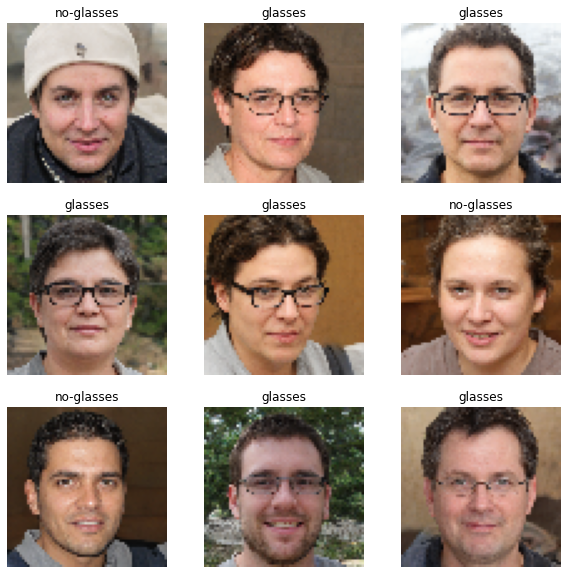

In [18]:
print_images(train_dataset)

In [19]:
#@title Code to display dynamically loss and accuracy curve

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(14,9))

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = len(train_dataset)

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend(prop={'size':14})
    self.axes[1].legend(prop={'size':14})
    self.axes[0].set_xlabel('epochs',fontsize=14)
    self.axes[1].set_xlabel('epochs',fontsize=14)
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

# First try with a basic neural network

In [20]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,3,)),
      tf.keras.layers.Reshape((IMG_SIZE*IMG_SIZE*3,), input_shape=((IMG_SIZE,IMG_SIZE,3,))),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 12289     
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


Learning rate decay callback

In [21]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback: decreasing learning rate every epoch passes
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

plot_training = PlotTraining(sample_rate=10, zoom=1)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)

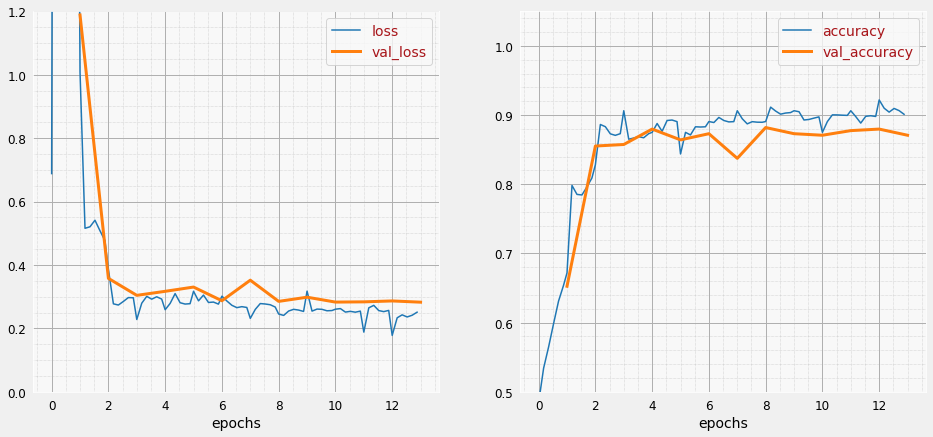

In [22]:
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=EPOCHS, verbose = 1,
  callbacks=[plot_training, stop_early, lr_decay_callback]
)

# First test with Convolutional Neural Network, optimized for images

Basic convolutional neural network

In [23]:
def first_cnn():
  model_cnn = tf.keras.models.Sequential([
                                          tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3), padding='same'),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(128, activation='relu'),
                                          tf.keras.layers.Dense(1, activation='sigmoid')
  ]
  )
  model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_cnn

In [24]:
model_cnn = first_cnn()
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

##64x64

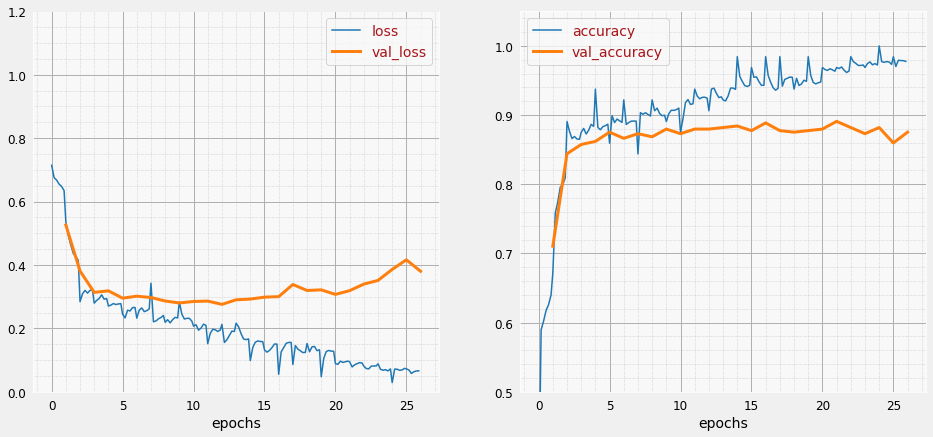

In [25]:
plot_training = PlotTraining(sample_rate=10, zoom=1)
history = model_cnn.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[plot_training, stop_early])

In [26]:
with open('/content/trainHistoryDict'+str(IMG_SIZE), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

##128x128

In [27]:
IMG_SIZE = 128
train_dataset, val_dataset, test_dataset = get_train_val_dataset(TRAINING_DIR, VALIDATION_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE)

Found 3599 files belonging to 2 classes.
Found 449 files belonging to 2 classes.
Found 452 files belonging to 2 classes.


In [28]:
model_128 = first_cnn()

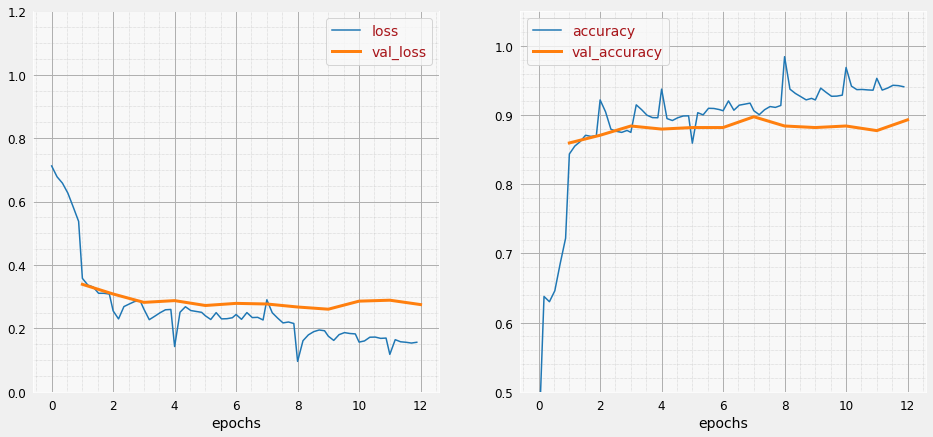

In [29]:
plot_training = PlotTraining(sample_rate=10, zoom=1)
history = model_128.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[plot_training, stop_early])

In [30]:
with open('/content/trainHistoryDict'+str(IMG_SIZE), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [31]:
IMG_SIZE = 256
train_dataset, val_dataset, test_dataset = get_train_val_dataset(TRAINING_DIR, VALIDATION_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE)

Found 3599 files belonging to 2 classes.
Found 449 files belonging to 2 classes.
Found 452 files belonging to 2 classes.


##256x256

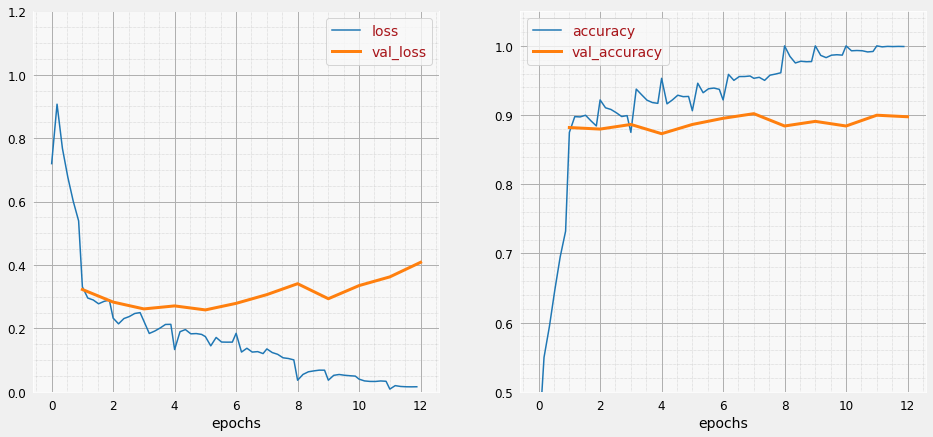

In [32]:
model_256 = first_cnn()

plot_training = PlotTraining(sample_rate=10, zoom=1)
history = model_256.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[plot_training, stop_early])

In [33]:
with open('/content/trainHistoryDict'+str(IMG_SIZE), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [34]:
df_64 = pd.read_pickle('/content/trainHistoryDict64')
df_128 = pd.read_pickle('/content/trainHistoryDict128')
df_256 = pd.read_pickle('/content/trainHistoryDict256')

df_64_pd = pd.DataFrame.from_dict(df_64)
df_128_pd = pd.DataFrame.from_dict(df_128)
df_256_pd = pd.DataFrame.from_dict(df_256)

In [35]:
df_to_plot = pd.DataFrame({'image_size': ['64', '128',
                              '256'],
                   'val_accuracy': [df_64_pd['val_accuracy'].mean(), df_128_pd['val_accuracy'].mean(), df_256_pd['val_accuracy'].mean()]})

In [36]:
df_to_plot

,image_size,val_accuracy
0,64,0.868254
1,128,0.881403
2,256,0.888456


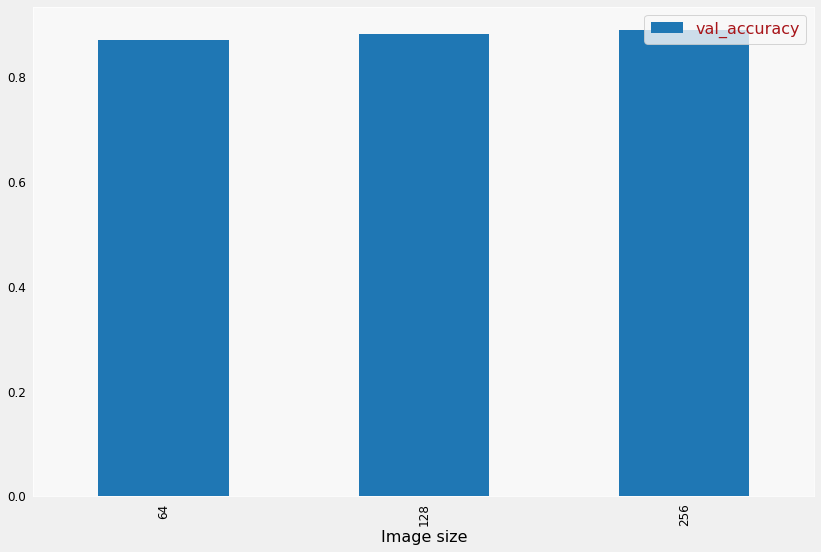

<Figure size 504x504 with 0 Axes>

In [37]:
df_to_plot.set_index('image_size').plot.bar()
plt.xlabel('Image size', fontsize=16)
plt.legend(fontsize=16,loc=0)
plt.figure(figsize=(7, 7))
plt.show()

We decided to use  an image size of 128x128 for the subsequent experiments since it is slightly better than 64x64 and the training time does not increase significantly. 

Introducing a Dropout layer after the conv2D layers to reduce overfitting.

In [38]:
IMG_SIZE = 128
train_dataset, val_dataset, test_dataset = get_train_val_dataset(TRAINING_DIR, VALIDATION_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE)

Found 3599 files belonging to 2 classes.
Found 449 files belonging to 2 classes.
Found 452 files belonging to 2 classes.


In [39]:
model_cnn_dropout = tf.keras.models.Sequential([
                                        tf.keras.layers.Conv2D(12, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3), padding='same'),
                                        tf.keras.layers.MaxPooling2D(2,2),
                                        tf.keras.layers.Conv2D(24, (3,3), activation='relu', padding='same', strides=2),
                                        tf.keras.layers.MaxPooling2D(2,2),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(128, activation='relu'),
                                        tf.keras.layers.Dropout(0.4),
                                        tf.keras.layers.Dense(1, activation='sigmoid')
]
)
model_cnn_dropout.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 12)      336       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 12)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 24)        2616      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 24)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               786560    
_________________________________________________________________
dropout (Dropout)            (None, 128)              

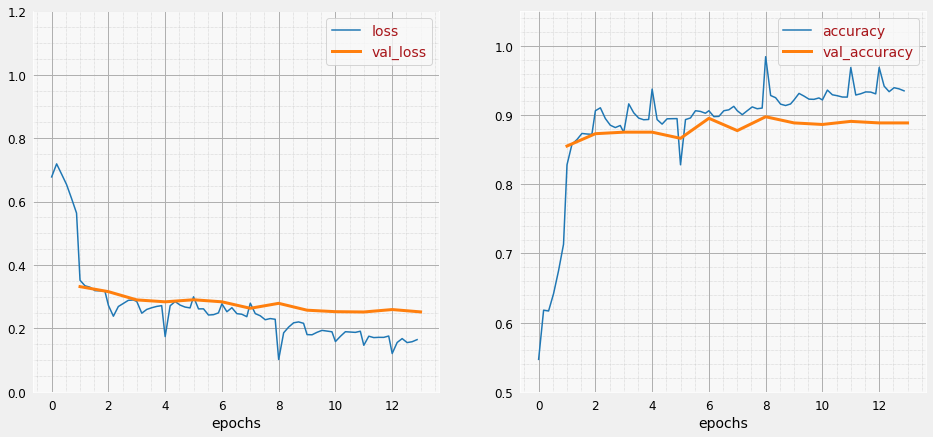

In [40]:
plot_training = PlotTraining(sample_rate=10, zoom=1)
model_cnn_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model_cnn_dropout.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[plot_training, stop_early])

Since we're not getting better results with the Dropout layer, we use the batch normalization layer that allows every layer of the network to do learning more independently.

We also add another conv2D layer to reduce the number of connections going in the last fully connected layer.  

In [41]:
def cnn_batch_norm():
  batch_norm = tf.keras.models.Sequential([
                                          tf.keras.layers.Conv2D(12, kernel_size=3, input_shape=(IMG_SIZE,IMG_SIZE,3), padding='same', use_bias=False),
                                          tf.keras.layers.MaxPooling2D(),
                                          tf.keras.layers.BatchNormalization(center=True,scale=False),
                                          tf.keras.layers.Activation('relu'),
                                          

                                          tf.keras.layers.Conv2D(24, kernel_size=3, padding='same', strides=2, use_bias=False),
                                          tf.keras.layers.MaxPooling2D(),
                                          tf.keras.layers.BatchNormalization(center=True,scale=False),
                                          tf.keras.layers.Activation('relu'),

                                          tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', strides=2, use_bias=False),
                                          tf.keras.layers.MaxPooling2D(),
                                          tf.keras.layers.BatchNormalization(center=True,scale=False),
                                          tf.keras.layers.Activation('relu'),
                                          
                                          tf.keras.layers.Flatten(),
                                          
                                          tf.keras.layers.Dense(200, use_bias=False),
                                          tf.keras.layers.BatchNormalization(center=True,scale=False),
                                          tf.keras.layers.Activation('relu'),
                                          
                                          tf.keras.layers.Dense(1, activation='sigmoid')
  ]
  )
  return batch_norm

In [42]:
model_cnn_batch_norm = cnn_batch_norm()
model_cnn_batch_norm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

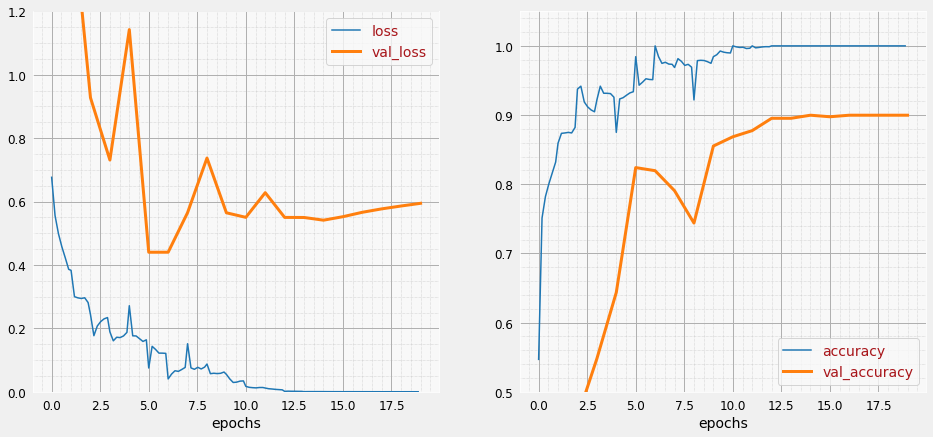

In [43]:
plot_training = PlotTraining(sample_rate=10, zoom=1)
history=model_cnn_batch_norm.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[plot_training, stop_early])

Since the network is learning too fast from the training dataset, we use the learning rate decay callback.

In [44]:
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

In [45]:
cnn_decay = cnn_batch_norm()

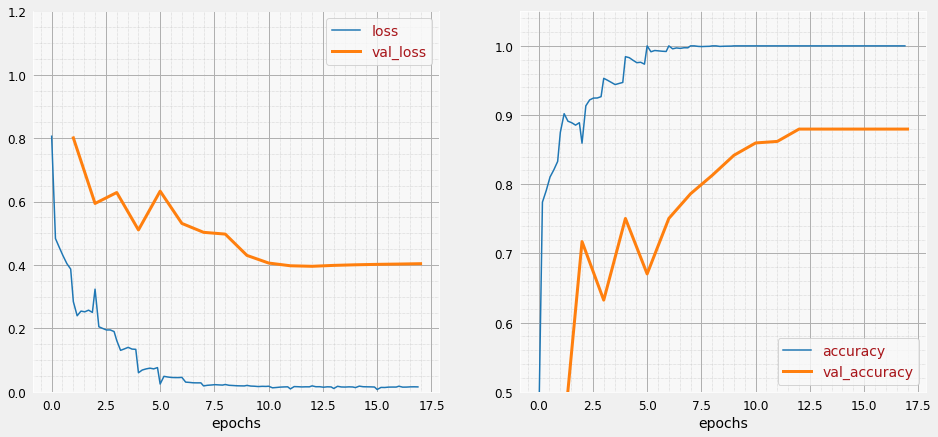

In [46]:
cnn_decay.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
plot_training = PlotTraining(sample_rate=10, zoom=1)
history=cnn_decay.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[plot_training, lr_decay_callback, stop_early])

We evaluate the last model with the test dataset, never seen by the model

In [47]:
eval_result = cnn_decay.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 16s 27ms/step - loss: 0.4318 - accuracy: 0.8894
[test loss, test accuracy]: [0.43178844451904297, 0.8893805146217346]


No better results in term of overfitting!

## Keras tuner

Since the optimal choice of the hyperparameters in a neural network is a difficult task, we rely on Keras Tuner.

In [48]:
RANDOM_TRIALS = 20
RANDOM_SEED = 1234

strategy =  tf.distribute.MirroredStrategy()

def model_builder(hp):
  model = tf.keras.models.Sequential()
  for i in range(hp.Int('num_layers', 2, 4)):
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv2d_filter'+str(i), min_value=12, max_value=64, step=32),
        kernel_size=hp.Choice('kernel'+str(i), values=[3,5]),
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        padding='same',))
    hp_pooling = hp.Choice('pooling'+str(i), values=['max', 'avg' ])
    if (hp_pooling == 'max'):
      model.add(tf.keras.layers.MaxPooling2D())
    else:
      model.add(tf.keras.layers.AveragePooling2D())
    model.add(tf.keras.layers.BatchNormalization(center=True,scale=False))
    model.add(tf.keras.layers.Activation('relu'))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=200, step=32),
      activation='relu'
  ))
  model.add(tf.keras.layers.Dense(
      units=1,
      activation='sigmoid'
  ))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
  return model


tuner = kt.Hyperband(model_builder,
                        objective='val_accuracy',
                        project_name='new_20_epochs',
                        distribution_strategy=strategy,
                        seed = RANDOM_SEED,
                        max_epochs=20,
                        overwrite=True
                        )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3)
tuner.search(train_dataset, validation_data=val_dataset, callbacks=[stop_early])

Trial 30 Complete [00h 00m 38s]
val_accuracy: 0.8953229188919067

Best val_accuracy So Far: 0.8953229188919067
Total elapsed time: 00h 13m 31s
INFO:tensorflow:Oracle triggered exit


In [49]:
best_hps=tuner.get_best_hyperparameters()[0]
print(f"""
The optimal number of conv2D layers is {best_hps.get('num_layers')}; 
the optimal number of units in the last Dense layer is {best_hps.get('units')} 
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The optimal number of conv2D layers is 2; 
the optimal number of units in the last Dense layer is 128 
and the optimal learning rate for the optimizer is 0.0001.



In [50]:
for model in tuner.get_best_models(1):
    model.save("./saved_models/model_best")

model = tf.keras.models.load_model('./saved_models/model_best')

INFO:tensorflow:Assets written to: ./saved_models/model_best/assets


In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 12)      336       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 12)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 44)        4796      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 44)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 44)        1

We evaluate the results on the test set, never seen by any model.

In [52]:
eval_result = model.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 0s 20ms/step - loss: 0.2897 - accuracy: 0.8850
[test loss, test accuracy]: [0.2896948754787445, 0.8849557638168335]


---
Manually removing all misclassified images

In [53]:
!rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3552.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-861.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1392.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2619.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1730.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2315.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1154.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3388.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-404.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1324.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1330.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1307.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3124.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2947.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3614.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2883.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4036.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1884.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4122.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2696.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3572.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1282.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2115.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2819.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-242.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3481.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1567.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-863.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-842.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1239.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1145.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1078.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1133.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1791.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1169.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3059.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1293.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4158.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4218.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1784.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3871.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2875.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4461.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1876.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-366.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1803.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-30.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2726.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4293.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2145.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2991.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-544.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2664.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-181.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1563.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3108.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-45.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1438.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3354.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2971.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1945.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3608.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3178.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3757.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2786.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3050.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1922.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1620.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-665.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4231.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-778.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1077.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1418.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-797.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-836.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3379.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3523.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3697.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3630.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1341.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1390.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4296.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4436.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-964.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-715.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-953.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-409.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-954.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2051.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1308.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1863.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4372.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-522.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2988.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2295.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3945.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3214.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-31.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3683.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2129.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4352.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1537.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-210.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1721.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3740.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4338.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-441.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-998.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3551.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1488.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2691.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2298.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3510.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2444.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1903.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2937.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-305.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1907.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-951.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3471.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3908.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1203.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-722.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1644.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2258.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2820.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3649.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3611.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1859.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-787.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1852.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4179.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-338.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-432.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4272.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-723.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2113.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-377.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2901.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2906.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1148.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1348.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1054.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4375.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2431.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4105.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3060.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3361.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-582.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2142.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-940.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1275.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2260.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-866.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3394.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-324.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2853.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-945.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2091.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-478.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1993.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2530.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1279.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3535.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4278.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-151.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2114.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3802.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2910.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1810.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-673.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-349.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1639.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3628.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3298.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2679.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3504.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-744.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3344.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2042.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-966.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3040.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-120.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4021.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1707.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3030.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4155.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-195.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1737.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4017.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2220.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3360.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4474.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2896.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-58.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4214.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1961.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-381.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2678.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3055.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1427.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1132.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3717.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1236.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3005.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2275.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-976.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3875.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1048.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2675.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2359.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2809.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-486.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1782.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2248.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1987.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-680.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2736.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2338.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1556.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1284.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-605.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-527.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-272.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-494.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-637.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1369.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1359.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-491.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3094.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-636.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1128.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2893.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-908.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-359.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2771.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4485.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2200.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2036.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4120.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4108.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2339.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2916.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3984.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-782.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-437.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-524.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3290.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2256.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3921.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2286.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4094.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-653.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2629.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-699.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-928.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3530.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4124.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3148.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3072.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2372.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2703.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-999.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3723.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2498.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1520.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2121.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1594.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2396.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2637.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3662.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-85.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-89.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-71.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1552.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-755.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3305.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-796.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2943.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2177.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-882.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3334.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3753.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3527.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3769.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3011.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4357.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2548.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3542.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3179.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1708.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3588.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3892.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3566.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2149.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3461.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-516.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4142.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-98.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1856.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1131.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-629.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3524.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3165.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3261.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3609.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1319.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1507.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2705.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4363.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-461.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-709.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2914.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3071.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1497.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2267.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2917.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3331.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4052.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3814.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2137.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1763.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3335.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1108.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3051.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2116.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2541.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1111.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1180.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-613.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2522.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-843.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1349.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1218.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2411.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1357.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-774.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2016.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3910.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2572.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1378.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2837.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3888.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-878.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3472.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-497.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1182.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3933.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1345.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2731.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2136.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1015.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1146.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-287.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2992.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1889.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3091.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3102.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3109.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3495.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1268.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3905.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-577.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2603.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1757.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3603.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3658.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4080.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-684.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2864.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2192.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1167.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1242.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2605.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2646.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3239.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3834.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2870.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-558.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2556.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3704.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-608.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3211.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1381.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-177.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1902.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1804.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1318.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4056.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-831.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2165.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4121.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4348.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2441.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2621.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1102.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4023.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3845.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3884.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1176.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3363.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1615.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3127.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4260.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1075.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2889.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3213.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3452.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3878.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2450.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1681.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-538.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3483.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1101.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4210.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-108.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1956.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-106.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1020.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4401.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-119.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2718.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-107.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3190.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1526.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-105.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2161.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2591.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4493.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3003.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3186.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1226.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4170.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2182.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-707.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1252.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2529.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-453.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1793.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3708.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-443.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4362.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4298.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2094.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2740.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1565.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-996.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2900.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-912.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-639.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4403.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2234.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2575.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2761.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3384.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2348.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4349.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3439.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-452.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1220.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-762.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3986.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2676.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3017.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-690.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1574.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1332.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2792.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3218.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1199.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-411.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2588.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-972.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2753.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2218.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3255.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4053.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4228.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3500.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2540.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2453.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1613.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3684.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-992.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-154.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3518.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2262.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1887.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-748.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1129.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1401.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1055.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4286.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1715.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3209.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2473.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4079.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1296.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-827.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-428.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-858.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1411.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3768.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1573.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3864.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1196.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-644.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2505.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2977.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-1646.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3929.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3057.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4275.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2573.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-575.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-4411.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2604.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2027.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2151.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3317.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-3849.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-2663.png ; rm ./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-521.png ; 

Emptying old directories to save space.

In [54]:
!rm -f /content/img/glasses/*
!rm -f /content/img/no-glasses/*

In [55]:
if len(os.listdir('./img/glasses')) == 0:
  # variables used to count how much images have glasses or not
  num_glasses = 0
  num_no_glasses = 0

  # splitting images in two folders: glasses and no glasses
  for glasses_label in train_latent[['id','glasses']].iterrows():
    str_img = "face-"+str(glasses_label[1]['id'])+".png"
    old_path = original_path+str_img
    if (glasses_label[1]['glasses'] == 0):
      new_dir = "img/no-glasses"
      num_no_glasses += 1
    else:
      new_dir = "img/glasses"
      num_glasses += 1
    try:
      shutil.move(old_path, new_dir)
    except:
      continue

In [56]:
shutil.rmtree('/content/splitted_img')
splitfolders.ratio("img", output="splitted_img", seed=RANDOM_SEED, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 3977 files [02:19, 28.57 files/s]


In [57]:
train_dataset, val_dataset, test_dataset = get_train_val_dataset(TRAINING_DIR, VALIDATION_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE)

Found 3181 files belonging to 2 classes.
Found 396 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [58]:
tuner = kt.Hyperband(model_builder,
                        objective='val_accuracy',
                        project_name='correct_images_20',
                        distribution_strategy=strategy,
                        seed = RANDOM_SEED,
                        overwrite=True,
                        max_epochs=20)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3)
tuner.search(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[stop_early])

Trial 30 Complete [00h 00m 14s]
val_accuracy: 0.9166666865348816

Best val_accuracy So Far: 0.9898989796638489
Total elapsed time: 00h 14m 18s
INFO:tensorflow:Oracle triggered exit


In [59]:
for model in tuner.get_best_models(1):
    model.save("./saved_models/model_best_clean_data")

model = tf.keras.models.load_model('./saved_models/model_best_clean_data')
model.summary()

INFO:tensorflow:Assets written to: ./saved_models/model_best_clean_data/assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 12)      912       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 12)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 44)        4796      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 44)        0         
___________________________________________

Finally we evaluate on unseen data

In [60]:
eval_results = model.evaluate(test_dataset)

7/7 [==============================] - 14s 44ms/step - loss: 0.1006 - accuracy: 0.9900
